# Logistic Regression

## 1- Description
- Response variable is qualitative

- We will first start with a classification problem with a 2 class response variable
- We will then apply Linear Regression to it
- We will then apply Logistic Regression and show how the results differ.

When the problem is one of classification, we can either discuss which category a certain observation should be classified as or we can discuss the probability of this observation being a part of a particular class. We will see that one implies the other. We choose the well known Titanic dataset in order apply these techniques to.

## 2- Titanic Dataset

We obtain the Titanic dataset from https://www.kaggle.com/c/titanic/data. 

The titanic dataset has data on the passengers of the Titanic catastrophe and whether they had survived the event or not.

These are the columns of the dataset:

- PassengerId: Passenger ID
- Pclass: Passenger Class
- Name: Name of passenger
- Sex: Sex of passenger
- Age: Age of passenger
- SibSp: Number of Siblings/Spouses of the passenger aboard
- Parch Number: of Parents/Children of the passenger aboard
- Ticket: Ticket Number
- Fare: Passenger Fare
- Cabin: Cabin
- Embarked: Port of Embarkation

The goal is to predict whether a passenger did survive or not

The response variable is 'Survived' and has 2 classes; 0 corresponding to 'did not survive' and 1 corresponding to 'survived'.

First we import some libraries

In [1]:
# Import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from numpy.random import RandomState
import math
%matplotlib inline

Next we import the 'Titanic.csv' file containing the data

In [2]:
titanic = pd.read_csv('Titanic.csv')

We can check to see what the dataset looks like

In [3]:
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


We can say a few things about the above:

- PassengerId probably doesn't mean anything and is just the ID of the passengers. In order to be sure we will plot this column against the Survived column to see if there is a correlation
- We could expect the qualitative column Pclass to have a correlation with survival. If indeed this column represent the quality of the room, activities, this would imply a separation of the poor and rich. 
- The name column could largely be useless apart from the title embedded within the name string. We could extract the title. The title of a person may give insight into the importance of this person and hence the likelihood of them surviving and getting of the ship before the ship sinks
- We definitely expect gender to have an impact on survival. It is common that females would be allowed to disembark first.
- Age is also expected to be an indicator of survival. The term 'Women and Children first' is descriptive of group mentality of such catastrophic situations
- SibSp and Parch are both expected to have a similar effect since they both indicate the family size
- Ticket could be an indicator is the ticket nuimber can be extracted. i.e. the ticket number may be the order of distribution of tickets to travellers. The priviledged may be given tickets first. Or they may be a natural ordering of tickets according to the location within the ship. It is clear that the location within the ship could be an indicator of how easy it is to reach safety
- Fare would be a clear indicator since this is indicative of how wealthy an individual is
- Cabin could be an indicator in the sense that the existence of a cabinmay indicate a wealthier individual/family. 
- Embark location may indicate the location on the ship if the Embark order is of importance

We create a copy of the dataset in order to experiment on without affecting the original dataset and look at correlations between the columns

In [4]:
# Create a dataframe for EDA (Exploratory Data Analysis) purposes
titanicEDA =titanic.copy()

titanicEDA.corr()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012658
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.012658,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


We can see from the above correlation information that some columns are correlated. For instance, Fare is an indicator of survival. Parch, Fare and SibSp seem correlated.

We can check to see if there are any missing data using a heatmap

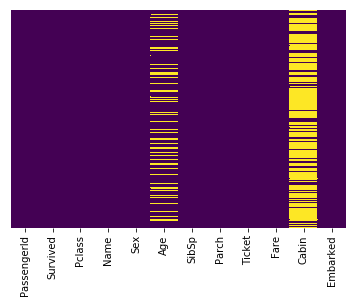

In [5]:
sns.heatmap(titanicEDA.isnull(),yticklabels=False,cbar=False,cmap='viridis')

It is clear that the Age missing data will need to be dealt with. Possible approaches could be to assign he age for each passenger for which this is missing, the average age of those with the same Sex and Pclass. Other approaches may involve the median or considering SibSp and Parch as well. However, here we will keep it relatively simple.

We can display the above in terms of percentage data missing as follows

In [6]:
print("Percentage of Age == NaN values: ", 100*np.sum(pd.isnull(titanicEDA['Age']))/np.size(titanicEDA['Age']))
print("Percentage of Cabin == NaN values: ", 100*(1 - titanicEDA['Cabin'].count()/np.size(titanicEDA['Cabin'])))

Percentage of Age == NaN values:  19.865319865319865
Percentage of Cabin == NaN values:  77.1043771043771


We can have a quick look, via barplots, the relationship between the categorical variables and the Survived column 

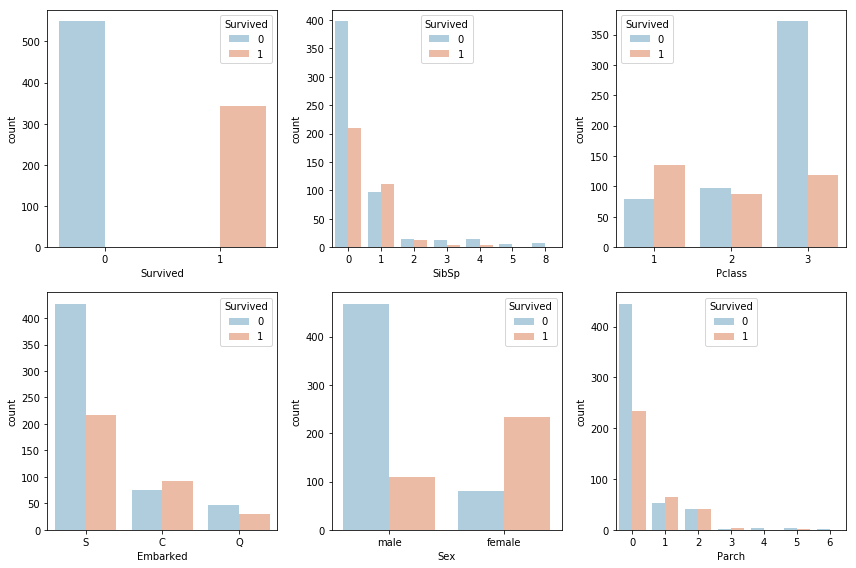

In [7]:
# The fields we want to look at
fields = ['Survived','SibSp','Pclass','Embarked','Sex','Parch']

# The number of rows and columns in the figure
nrows = 2
ncols = int(len(fields)/nrows)

# Obtain the figure and axes handles
fig,ax = plt.subplots(nrows=nrows,ncols=ncols,figsize=(ncols*4,nrows*4))

# Iterate through the rows and columns of the figure and plot the respective element within fields in that row/col
for row in range(0,nrows):
    for col in range(0,ncols):
        thisAxis = ax[row][col]
        field = row*ncols + col
        
        # We cannot plot an element that doesn't exist
        if field >= len(fields):
            continue
        sns.countplot(x=fields[field],hue=fields[0],data=titanicEDA,palette='RdBu_r',ax=thisAxis)
        
plt.tight_layout()  

This gives us some initial insight into whether a categorical variable could be useful in our models or not. 

Some insights are as follows:

- The data is highly skewed in the sense that there are more passengers that have not survived
- Those with no siblings or spouses have a lower rate of survival
- If the passenger was in Pclass 3, that passenger has a very bad rate of survival compared to the other classes
- If the passenger had embarked at 'S', that passenger has a lower survival probability than the other embarked locations
- The Sex plot indicates that the 'Women and Children first' comment may indeed be true.
- The Parch and SibSp columns seem to have the same effect

Next, we will have a look at how Age is related to survival

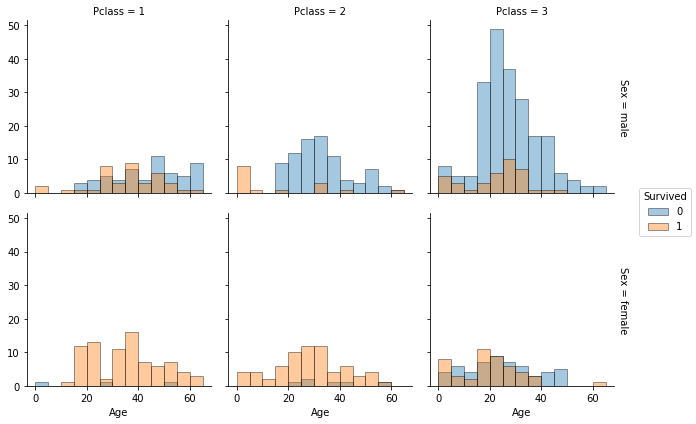

In [8]:
g = sns.FacetGrid(data=titanicEDA,row='Sex',col='Pclass',hue='Survived',margin_titles=True)

g.map(sns.distplot, 'Age', kde=False,bins=np.arange(0,70,5),hist_kws=dict(edgecolor='black'))

g.add_legend() 

plt.show()  

We can see from the above distributions that:

- Males had best survival rates in Pclass 1
- Females had best survival rates in Pclass 1 and 2
- For females, being very young in Pclass 1 meant you had greater chance of death. While being in Pclass 2 meant greater chance of survival

Let's create a TotalPpl column and see how that correlates with survival

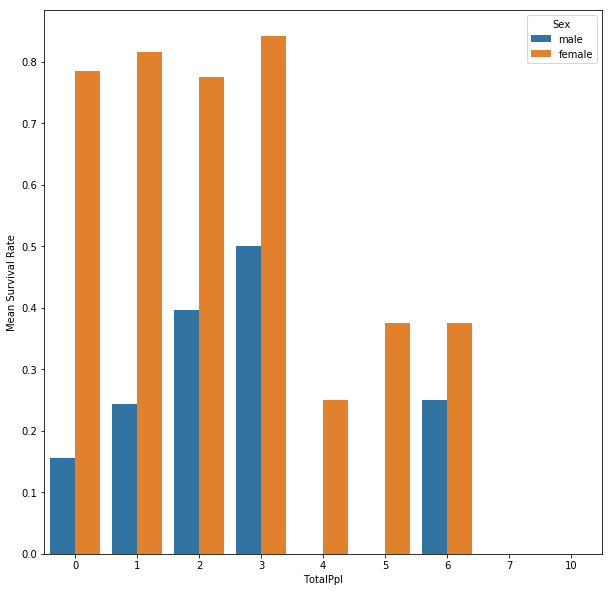

In [9]:
titanicEDA['TotalPpl'] = titanicEDA['Parch'] + titanicEDA['SibSp']

fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(10,10))

sns.barplot(x='TotalPpl',y='Survived',hue='Sex',data=titanicEDA,ci=0)

ax.set_ylabel('Mean Survival Rate')

plt.show()

When viewed all together, it looks like there is no relationship between TotalPpl and Survival. However, looking at this data split by gender shows that as the size of a passengers family increases toward 3, male passenger survival rates increase while female passenger survival rates remain constant. Increasing the family size further dramatically decreases survival rates.

Next, let's look at passenger titles to see if there is any insight there.

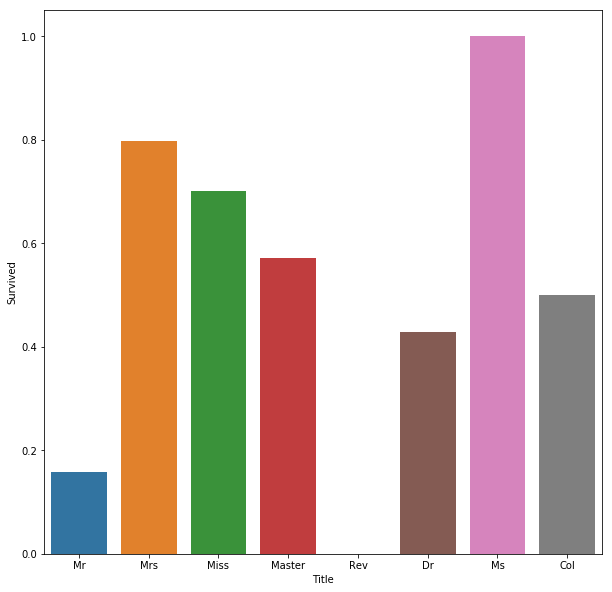

In [10]:
def getTitleFromTitanic(x):
    '''
    A function to extract the title from a passenger name
    x:= Name of passenger
    '''
    for elt in x.split():
        if('.' in elt):
            return elt.replace('.','')
    return ''

#Get the title from the name
titanicEDA['Title'] = titanicEDA['Name'].apply(getTitleFromTitanic)

dic_OrigMap = {'Mr': 'Mr', 'Mrs': 'Mrs', 'Miss': 'Miss', 'Master':'Master','Don':'Don','Rev':'Rev',
    'Mme':'Mme',
    'Ms':'Ms','Major':'Major', 'Lady':'Lady', 'Sir':'Sir', 'Mlle':'Mlle', 
    'Col':'Col', 'Capt':'Capt', 'Countess':'Countess','Jonkheer':'Jonkheer', 'Dr':'Dr', 'Dona':'Dona'}

dic_Map = {'Mr': 'Mr', 'Mrs': 'Mrs', 'Miss': 'Miss', 'Master':'Master','Don':'Mr','Rev':'Rev',
    'Mme':'Mrs',
    'Ms':'Ms','Major':'Mr', 'Lady':'Mrs', 'Sir':'Master', 'Mlle':'Miss', 
    'Col':'Col', 'Capt':'Rev', 'Countess':'Mrs','Jonkheer':'Master', 'Dr':'Dr', 'Dona':'Mrs'}

titanicEDA['Title'] = titanicEDA['Title'].map(dic_Map)

# Plot
fig,ax = plt.subplots()
sns.barplot(x='Title',y='Survived',data=titanicEDA,ci=0)
fig.set_size_inches(10,10)

From the above plot we can see that Reverands have the worst survival rates (we check below to see how reliable this statement is by looking at how many 'Rev's there actually was. There were 7, so not so unreliable). Those with the title of 'Mr' had the next worst survival rates.

In [11]:
titanicEDA[titanicEDA['Title'] == 'Rev']['PassengerId'].count()

7

Next we obtain the ticket number as discussed above to see if there is indication of a relationship between survival and the ticket number

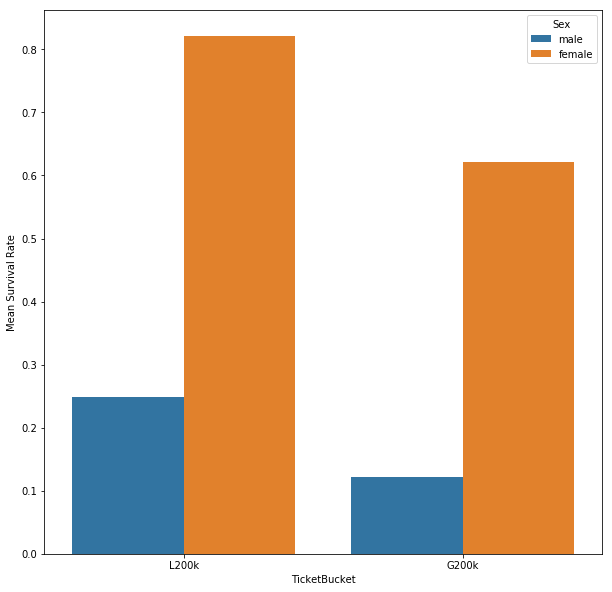

In [12]:
def GetTicketNo(x):
    a = x.split()
    n = len(a)
    if n == 1:
        if(a[0] != 'LINE'):
            return int(a[0])
        else:
            return 0
    else:
        return int(a[n-1])

# Bucket the data into greater than 200k and less than 200k
titanicEDA['TicketBucket'] = (titanicEDA['Ticket'].apply(GetTicketNo)).apply(lambda x: 'G200k' if x > 200000 else 'L200k')

# Plot the data
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(10,10))

sns.barplot(x='TicketBucket',y='Survived',hue='Sex',data=titanicEDA,ci=0)

ax.set_ylabel('Mean Survival Rate')

plt.show()

It looks like there is evidence that those with a lower ticket number had greater survival rates for both males and females

Next let's look at whether we can see anything interesting with the Cabin variable

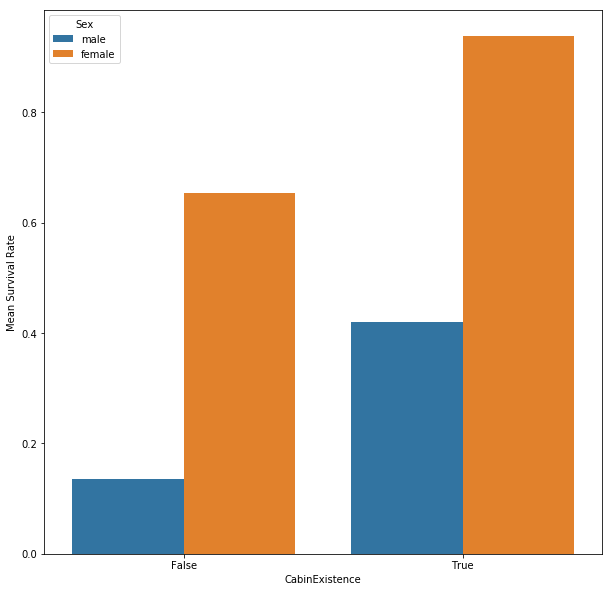

In [13]:
#Cabin either exists or doesn't -> 1 or 0
titanicEDA['CabinExistence'] = pd.isnull(titanicEDA['Cabin']).apply(lambda x: not x)

fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(10,10))

sns.barplot(x='CabinExistence',y='Survived',hue='Sex',data=titanicEDA,ci=0)

ax.set_ylabel('Mean Survival Rate')

plt.show()

The existence of a cabin indicates a greater survival rate. 

We can further disect the dataset by looking at name lengths and the letters within the Cabin name but we put an end to the EDA at this point since the purpose of this article is to demonstrate and discuss Logistic Regression in general and not exhaust the Titanic Dataset.

Below, we introduce a function to clean and transform this dataset according to what we have observed above in order to smoothly apply the concepts which follow and keep the flow of discussion going smoothly without having to Ad-Hoc transform the data. 

In [14]:
def getTitleFromTitanic(x):
    '''
    A function to extract the title from a passenger name
    x:= Name of passenger
    '''
    for elt in x.split():
        if('.' in elt):
            return elt.replace('.','')
    return ''

def GetFirstCharacter(st):
    '''
    A function to extract the first letter (lower case) from a string. If string is null then output is an empty string
    st: A string
    '''
    if(pd.isnull(st) or len(st)==0):
        return 0
    else:
        return ord(st[0].lower())
    
def AddTotalPpl(df):
    '''
    A function to add the Parch and SibSp into a new column called 'TotalPpl'
    '''
    df_temp = df.copy()
    df_temp['TotalPpl'] = df['Parch'] + df['SibSp']
    return df_temp

def CleanTitanicData(df):
    '''
    A function to clean the titanic dataframe according to the EDA above
    '''
    
    #Sex is either male or female. Create a series which has entries 0 and 1 specifying whether it's one or the other
    sex = pd.get_dummies(df['Sex'],drop_first=True)
    
    #Similar to the sex series
    embark = pd.get_dummies(df['Embarked'],drop_first=True)
    
    #Cabin either exists or doesn't -> 1 or 0
    Cabin = pd.DataFrame(pd.isnull(df['Cabin']).apply(lambda x: not x),columns=['Cabin'])
    
    # Get the ticket number and then bucket them into >200000 and < 200000
    df['TicketBucket'] = (df['Ticket'].apply(GetTicketNo)).apply(lambda x: 'G200k' if x > 200000 else 'L200k')
    TicketBucket = pd.get_dummies(df['TicketBucket'],drop_first=True)
    
    #Get first letter of cabin
    #Cabin = df['Cabin'].apply(GetFirstCharacter)
    
    #Get the title from the name
    df['Title'] = df['Name'].apply(getTitleFromTitanic)
    
    df['Title'] = df['Title'].map(dic_Map)
    
    Title =  pd.get_dummies(df['Title'],drop_first=True)
    
    # Get the name lenth and bucket it
    df['NameLengthBucket'] = df['Name'].apply(lambda x: int(len(x)/10)*10)
    
    #Get rid of some columns
    df_temp = df.drop(['Sex','Embarked','Name','Ticket','Cabin','Title','TicketBucket'],axis=1,inplace=False)
    
    #Concat the series to the data frame
    df_temp = pd.concat([df_temp,sex,embark,Cabin,Title,TicketBucket],axis=1)
    
    df_temp['TotalPpl'] = df['Parch'] + df['SibSp']
    
    return df_temp


def setAge(row,meanAge):
    '''
    This function is intended to be used via the apply() funtion and applies to rows in the format (Age,sex,Pclass).
    This function replaces any null Age with the mean Age of the same sex and Pclass as given in the meanAge argument/dataframe.
    '''
    Age = row[0]
    male = row[1]
    Pclass = row[2]
    if(pd.isnull(Age)):
        return int(meanAge[(meanAge['Pclass'] == Pclass) & (meanAge['male'] == male)]['Age'].iloc[0])
    else:
        return int(Age)
    
def setFare(row,meanFare):
    '''
    This function is intended to be used via the apply() funtion and applies to rows in the format (Fare,sex,Pclass).
    This function replaces any null Fare with the mean Fare of the same sex and Pclass as given in the meanFare argument/dataframe.
    '''
    Fare = row[0]
    male = row[1]
    Pclass = row[2]
    if(pd.isnull(Fare)):
        return int(meanFare[(meanFare['Pclass'] == Pclass) & (meanFare['male'] == male)]['Fare'].iloc[0])
    else:
        return int(Fare)
    
def fillTitanicNa(df,fillAge=True,fillFare=True):
    '''
    This function takes a titanic data frame, cleans it and fills in missing Age and Fare values. If it is desired
    that the Age not be filled the fillAge should be set to False. Likewise with fillFare.
    '''
    
    # Clean and transform the data
    df_temp = CleanTitanicData(df)

    # Get the mean Fare values per grouping
    t_Fare = pd.DataFrame(df_temp.dropna().groupby(['Pclass','male']).mean()['Fare'])
    t_Fare = pd.DataFrame(t_Fare.to_records())

    # Get the mean Age values per grouping
    t_Age = pd.DataFrame(df_temp.dropna().groupby(['Pclass','male']).mean()['Age'])
    t_Age = pd.DataFrame(t_Age.to_records())
    
    if(fillAge == True):
        df_temp['Age'] = df_temp[['Age','male','Pclass']].apply(lambda row: setAge(row,t_Age),axis=1)

    if(fillFare == True):
        df_temp['Fare'] = df_temp[['Fare','male','Pclass']].apply(lambda row: setFare(row,t_Fare),axis=1)
        
    if(fillAge == False or fillFare == False):
        df_temp.dropna(inplace = True)
        
    return df_temp


In [15]:
titanicCleaned = titanic.copy()
titanicCleaned = fillTitanicNa(titanicCleaned,True,True)

## 3- Linear Regression

Let's keep it simple and only consider the 'Age' variable as an explanatory variable for 'Survived'. The 'Survived' response variable is encoded as 0 for did not survive and 1 for survived. This gives a naturally ordered response variable and we can apply Logistic Regression to regress Survived onto Age.

The linear equation we are trying to fit is:

$$Y = \beta_0 + \beta_1 X_1$$

where $X_1$ is the Age parameter. We have a seperate article going in to the theory behind Linear Regression. Here we apply the model to drive the point across.

In [16]:
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import train_test_split

# Create our parameters X and response y
X = titanicCleaned['Age']
y = titanicCleaned['Survived']

# Reshape the data to indicate that this is many observations of one parameter
X = X.values.reshape(-1,1)
y = y.values.reshape(-1,1)

# Get the model
lm = LinearRegression()

# Fit the model
lm.fit(X,y)

print('The formula is:\n\n Y={} + {} * X_1'.format(lm.intercept_,lm.coef_[0]))

# Let's get the predictions
fitted = lm.predict(X)

# print the first 10 predictions
print('\n\n The first 10 fitted values')
print(fitted[0:10])

The formula is:

 Y=[0.4548291] + [-0.00243186] * X_1


 The first 10 fitted values
[[0.40132814]
 [0.36241835]
 [0.39160069]
 [0.36971393]
 [0.36971393]
 [0.39160069]
 [0.32350856]
 [0.44996537]
 [0.38916883]
 [0.42078303]]


C:\Users\HVAD\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


The residuals are expressed as

$$r_i = y_i - \hat{y}_i$$

and are calculated as follows

In [17]:
# Residuals
residuals = y - fitted
print('First 10 residuals')
print(residuals[0:10])

First 10 residuals
[[-0.40132814]
 [ 0.63758165]
 [ 0.60839931]
 [ 0.63028607]
 [-0.36971393]
 [-0.39160069]
 [-0.32350856]
 [-0.44996537]
 [ 0.61083117]
 [ 0.57921697]]


We may want to classify a passenger into the class 'Survived' if we predict a value greater than some threshold and did not survive otherwise. We create a function for this below and then predict the survival response variable for the test dataset using a threshold of 0.35

In [18]:
def Predict(model,X,threshold):
    '''
    This function assigns observations into predicted classes Not Survived and Survived
    model:= the Linear Regression model used to fit the training data
    X:= the observations
    threshold:= the value for which all predicted values smaller than this threshold is 
                classified as did not survive
    '''
    rawPrediction = model.predict(X)
    prediction = rawPrediction > threshold
    return list(map(lambda x: 1 if x else 0,prediction))

In [19]:
# Predict using a threshold of 0.35
print('The first 10 predictions using a threshold of 0.35')
print(Predict(lm,X,0.35)[0:20])

The first 10 predictions using a threshold of 0.35
[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1]


But which threshold do we use. One approach is to use the threshold which maximises accuracy. This is programatically done by looking at the ratio of successes we have achieved. For a threshold of 0.35 we roughly obtain a 39% prediction accuracy as shown below

In [20]:
print('The percentage of predictions that were correct is {}'.format(np.sum((Predict(lm,X,0.35) == y)[:,0])/np.size(y)))

The percentage of predictions that were correct is 0.3838383838383838


We can loop through the possible values of the threshold and choose the one with the best accuracy. This approach shows that the best accuracy we can attain is approximately 0.62 using only Age as a predictor variable

In [21]:
bestThreshold = 0
bestAccuracy = 0
for i in np.arange(0,1,0.001):
    accuracy = np.sum((Predict(lm,X,i) == y)[:,0])/np.size(y)
    if bestAccuracy < accuracy:
        bestAccuracy = accuracy
        bestThreshold = i

print('The best threshold is {thresh}. The corresponding accuracy is {acc}'.format(thresh = bestThreshold, acc = bestAccuracy))

The best threshold is 0.402. The corresponding accuracy is 0.6161616161616161


In reality, this threshold is dependent on the cost for incorrectly predicting a person has survived as opposed to the cost of incorrectly predicting a person has not survived. For example if incorrectly predicting a person has survived (False Positives) is orders of magnitude worse than incorrectly predicting a person has not survived (False Negatives), then we could expect the threshold to be placed much higher than 0.402 found above. This is because we want to be pretty sure that the passenger has survived before placing them into the survived class.

Let's plot the regression line onto the training data we used to fit the model

In [22]:
def RegLine(lm,x):
    Y=lm.intercept_ + lm.coef_[0] * x
    return Y

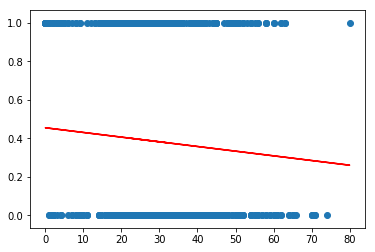

In [23]:
plt.scatter(x=X[:,0],y=y[:,0])

Y = RegLine(lm,X)

plt.plot(X[:,0],Y,'r-')


One may think at this point that Linear Regression would suffice for classification problems. However, when more than two classes are involved in the response variable, it does not make sense to fit a straight line to the predicted classes. For example, suppose we would like to predict or model the relationship between income and favourite colour and we are only considering red, yellow and blue. The question would be 'How would we encode these classes?'. The answer is that with linear regression, we can't. The mapping red = 0, yellow = 1, blue = 2 would yield different results from red = 0, blue = 1, yellow = 2. This is because we are implying an order here that blue is greater than yellow which is greater than red. Additionally, there is no reason to assume that the difference between red and yellow is the same as yellow and blue. 

Another reason linear regression falls short in situations like this is that the resulting predicted value is not a probability. Although not clear in the model with Age above, the model with Fare below shows that a Fare greater than 300 will result in a value above 1. 

The formula is:

 Y=[0.30371598] + [0.00252071] * X_1


 The first 10 fitted values
[[0.32136096]
 [0.48268648]
 [0.32136096]
 [0.43731367]
 [0.32388167]
 [0.32388167]
 [0.43227225]
 [0.35665091]
 [0.3314438 ]
 [0.37933732]]


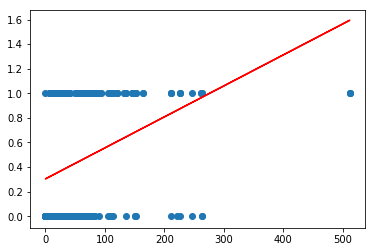

In [24]:
# Create our parameters X and response y
X = titanicCleaned['Fare']
y = titanicCleaned['Survived']

# Reshape the data to indicate that this is many observations of one parameter
X = X.values.reshape(-1,1)
y = y.values.reshape(-1,1)

# Get the model
lm1 = LinearRegression()

# Fit the model
lm1.fit(X,y)

print('The formula is:\n\n Y={} + {} * X_1'.format(lm1.intercept_,lm1.coef_[0]))

# Let's get the predictions
fitted = lm1.predict(X)

# print the first 10 predictions
print('\n\n The first 10 fitted values')
print(fitted[0:10])

plt.scatter(x=X[:,0],y=y[:,0])

Y = RegLine(lm1,X)

plt.plot(X[:,0],Y,'r-')

It is possible to map the values of y above to the interval [0,1] so that this condition for a probability function is satisfied. There are many functions that would satisfy this. Let us choose the following function

$$P: x \rightarrow [0,1]$$
$$P(x) = \frac{ \exp(\beta_0 + \beta_1 x) }{ 1 + \exp(\beta_0 + \beta_1 x) }$$

This satifies the requirement, as seen below. Another way to see this is looking at the limits $\lim_{\beta_1 x \rightarrow \infty} P(x) = 1$ and $\lim_{\beta_1 x \rightarrow -\infty} P(x) = 0$. This function is called the Logistic Function and is the basis for Logistic Regression, which we introduce in the next section. (The fit below is only for demonstration purposes and does not represent an actual fit of the logistic function to the data).

In [25]:
def LogisticFunction(x,beta0,beta1):
    numerator = list(map(lambda x: math.exp(beta0)*math.exp(x),x*beta1))
    denominator = list(map(lambda x: 1 + math.exp(beta0)*math.exp(x),x*beta1))
    return list(map(lambda x,y: x/y,numerator,denominator))

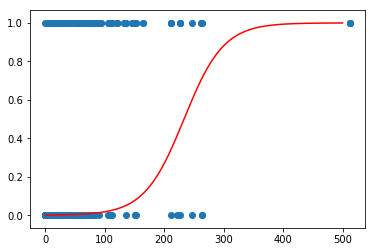

In [26]:
x = np.arange(0,500,0.1)

plt.scatter(x=X[:,0],y=y[:,0])

Y = LogisticFunction(x,-7,0.03)

plt.plot(x,Y,'r-')

## 4- Logistic Regression

As seen in the previous section, Logistic Regression offers solutions to the issues of Linear Regression for the cases where the response variable is qualitative. The logistic function, which is the target of the fitting process for Logistic Regression, is

$$P: x \rightarrow [0,1]$$
$$P(x) = \frac{ \exp(\beta_0 + \beta_1 x) }{ 1 + \exp(\beta_0 + \beta_1 x) }$$

We can manipulate the above to obtain the odds

$$\frac{ P(x) }{ 1-P(x) } = \exp(\beta_0 + \beta_1 x)$$

Then we can take the natural logarithm of both sides to obtain the logit or log-odds

$$\log(\frac{ P(x) }{ 1-P(x) }) = \beta_0 + \beta_1 x$$

This shows that the log-odds is a linear function of x. The task comes down to estimating the coefficients $\beta_0$ and $\beta_1$ such that the fit assigns as many entities to the correct class as possible. This is mathematically expressed as

$$\max_{\beta_0,\beta_1} I(y_i,\hat{y}_i)$$

where $\hat{y}_i$ are the predictions, $y_i$ are the observed responses and $I(y_i,\hat{y}_i) = 1$ if $y_i=\hat{y}_i$ and $I(y_i,\hat{y}_i) = 0$ otherwise. This is a type of *Maximum Lilkelihood Estimation* (MLE). Explicitly, define the likelihood of $\beta = (\beta_0,\beta_1)$ as being the probability of observing this particular outcome given the data just observed

$$L(\beta) = P(Y|\beta,x) = P(y_1,y_2,...,y_n|\beta,x)$$

where $x=(x_1,x_2,...,x_n)$ is the observed predictors. If we can assume independence in the sampling procedure, in other words that the random variables $X_i$ and $X_j$ are independent, then we have

$$L(\beta) = P(y_1|\beta,x_1) \times P(y_2|\beta,x_2) \times ... \times P(y_n|\beta,x_n)$$

Note that $P(y_n|\beta,x_1,x_2,...,x_n) = P(y_n|\beta,x_n)$ because we have assumed that $y_n$ is only dependent on the predictor $x_n$. Substituting for the actual observations

$$L(\beta) = P(y = 1|\beta,x_1) \times P(y = 1|\beta,x_2) \times ... \times P(y = 1|\beta,x_{n1}) \times P(y = 0|\beta,x_{n1+1}) \times P(y = 0|\beta,x_{n1+2}) \times ... \times P(y = 0|\beta,x_n)$$

where for convenience we have ordered all the observations from class 1 first followed by the observations from class 0. Noting that $P(y = 0|\beta,x) = 1 - P(y = 1|\beta,x)$ we can re-write the above equation as

$$L(\beta) = \prod_{i:y_i=1} P(y = 1|\beta,x_i) \prod_{i:y_i=0} (1-P(y = 1|\beta,x_i))$$

But $P(y = 1|\beta,x_i)$ is simply the logistic function above. i.e. the probability that this observation lies in class 1. Substitution results in

$$L(\beta) = \prod_{i=1}^{n1} \frac{ \exp(\beta_0 + \beta_1 x_i) }{ 1 + \exp(\beta_0 + \beta_1 x_i) } \prod_{i=n1+1}^n (1-\frac{ \exp(\beta_0 + \beta_1 x_i) }{ 1 + \exp(\beta_0 + \beta_1 x_i) })$$

where there are $n1$ observations from class 1. The task is to maximise this likelihood function. Noting that $a > b \implies \log{a} > \log{b} \; \forall \; a > 0$ we have that maximising this function corresponds to maximising the log of this function. The log-likelihood is then given as

$$l(\beta) = \log( \prod_{i=1}^{n1} \frac{ \exp(\beta_0 + \beta_1 x_i) }{ 1 + \exp(\beta_0 + \beta_1 x_i) } ) \log( \prod_{i=n1+1}^n (1-\frac{ \exp(\beta_0 + \beta_1 x_i) }{ 1 + \exp(\beta_0 + \beta_1 x_i) }) )$$

$$= \sum_{i=1}^{n1} \log( \frac{ \exp(\beta_0 + \beta_1 x_i) }{ 1 + \exp(\beta_0 + \beta_1 x_i) } ) \sum_{i=n1+1}^n \log(1-\frac{ \exp(\beta_0 + \beta_1 x_i) }{ 1 + \exp(\beta_0 + \beta_1 x_i) })$$

$$= \sum_{i=1}^{n1} \log( \exp(\beta_0 + \beta_1 x_i)) - \sum_{i=1}^{n1} \log(  1 + \exp(\beta_0 + \beta_1 x_i) ) -\sum_{i=n1+1}^n \log( 1 + \exp(\beta_0 + \beta_1 x_i) )$$

$$= \sum_{i=1}^{n1} (\beta_0 + \beta_1 x_i) - \sum_{i=1}^{n} \log(  1 + \exp(\beta_0 + \beta_1 x_i) )$$

We will need to maximise the log-likelihood with respect to $\beta$. We can take the following derivatives

$$f_1 = \frac{ \partial l }{ \partial \beta_0 } = n1 - \sum_{i=1}^n \frac{ \exp(A_i) }{ 1 + \exp(A_i) }$$

$$f_2 = \frac{ \partial l }{ \partial \beta_1 } = \sum_{i=1}^{n1} x_i - \sum_{i=1}^n \frac{ x_i \exp(A_i) }{ 1 + \exp(A_i) }$$

where for ease of notation $A_i = \beta_0 + \beta_1 x_i$. In order to find the roots of these two functions in a two dimensional setting, we can use the multidimensional Newton-Raphson method. This method is described as follows


$$\beta_{n+1} = \beta_{n} - J^{-1} (f_1(\beta_{n}),f_2(\beta_{n}))^T$$

$$J = \begin{bmatrix}
    \frac{ \partial f_1 }{ \partial \beta_0 }       & \frac{ \partial f_1 }{ \partial \beta_1 } \\
    \frac{ \partial f_2 }{ \partial \beta_0 }       & \frac{ \partial f_2 }{ \partial \beta_1 }
\end{bmatrix}$$

where $^T$ is the transpose. This method describes an iterative process by which we obtain the next estimate $\beta_{n+1}$ from the previous $\beta_{n}$. The elements of the Jacobian Matrix (J) are

$$\frac{ \partial f_1 }{ \partial \beta_0 } = - \sum_{i=1}^n \frac{ \exp(A_i) }{ (1 + \exp(A_i))^2 }$$

$$\frac{ \partial f_1 }{ \partial \beta_1 } = - \sum_{i=1}^n \frac{ x_i \exp(A_i) }{ (1 + \exp(A_i))^2 }$$

$$\frac{ \partial f_2 }{ \partial \beta_0 } = - \sum_{i=1}^n \frac{ x_i \exp(A_i) }{ (1 + \exp(A_i))^2 }$$

$$\frac{ \partial f_2 }{ \partial \beta_1 } = - \sum_{i=1}^n \frac{ x_i^2 \exp(A_i) }{ (1 + \exp(A_i))^2 }$$

Below, we can construct an iterative function to apply this method.

In [27]:
def f_1(b0,b1,X,Y):
    '''
    This is the function f_1 above. One of the functions we are trying to find the roots of
    b0:= beta_0
    b1:= beta_1
    X:= The observed predictors as a series
    Y:= The observed responses as a series
    '''
    return np.sum(Y) - np.sum(list(map(lambda x: x,LogisticFunction(X,b0,b1))))

def f_2(b0,b1,X,Y):
    '''
    This is the function f_1 above. One of the functions we are trying to find the roots of
    b0:= beta_0
    b1:= beta_1
    X:= The observed predictors as a series
    Y:= The observed responses as a series
    '''
    s = 0
    for i in range(0,len(X)):
        s += Y[i]*X[i]
    return s - np.sum(list(map(lambda x,y: x*y,X,LogisticFunction(X,b0,b1))))

def df_1b0(b0,b1,X,Y):
    '''
    This is element (1,1) of the Jacobian Matrix.
    b0:= beta_0
    b1:= beta_1
    X:= The observed predictors as a series
    Y:= The observed responses as a series
    '''
    m1 = LogisticFunction(X,b0,b1)
    m2 = list(map(lambda x: 1 + math.exp(b0+b1*x),X))
    return -np.sum(list(map(lambda x,y: x/y,m1,m2)))

def df_1b1(b0,b1,X,Y):
    '''
    This is element (1,2) of the Jacobian Matrix.
    b0:= beta_0
    b1:= beta_1
    X:= The observed predictors as a series
    Y:= The observed responses as a series
    '''
    m1 = X*LogisticFunction(X,b0,b1)
    m2 = list(map(lambda x: 1 + math.exp(b0+b1*x),X))
    return -np.sum(list(map(lambda x,y: x/y,m1,m2)))

def df_2b0(b0,b1,X,Y):
    '''
    This is element (2,1) of the Jacobian Matrix.
    b0:= beta_0
    b1:= beta_1
    X:= The observed predictors as a series
    Y:= The observed responses as a series
    '''
    m1 = X*LogisticFunction(X,b0,b1)
    m2 = list(map(lambda x: 1 + math.exp(b0+b1*x),X))
    return -np.sum(list(map(lambda x,y: x/y,m1,m2)))

def df_2b1(b0,b1,X,Y):
    '''
    This is element (2,2) of the Jacobian Matrix.
    b0:= beta_0
    b1:= beta_1
    X:= The observed predictors as a series
    Y:= The observed responses as a series
    '''
    m1 = X**2*LogisticFunction(X,b0,b1)
    m2 = list(map(lambda x: 1 + math.exp(b0+b1*x),X))
    return -np.sum(list(map(lambda x,y: x/y,m1,m2)))

def invJacob(b0,b1,X,Y):
    '''
    This function finds the inverse of the Jacobian Matrix
    b0:= beta_0
    b1:= beta_1
    X:= The observed predictors as a series
    Y:= The observed responses as a series
    '''
    # Calculate the delta
    delta = df_1b0(b0,b1,X,Y)*df_2b1(b0,b1,X,Y) - df_1b1(b0,b1,X,Y)*df_2b0(b0,b1,X,Y)
    
    # Calculate the elements of the jacobian matrix and form 2 vectors (the rows of the inverse of the matrix)
    a1 = np.array((df_2b1(b0,b1,X,Y),-df_1b1(b0,b1,X,Y)))
    a2 = np.array((-df_2b0(b0,b1,X,Y),df_1b0(b0,b1,X,Y)))
    
    # Return the inverse as a matrix
    return (1/delta)*np.array([a1,a2])

def IterRaphson(b0_0,b1_0,X,Y):
    '''
    This function is the iterative step. Given initial values of beta, this function will
    give the new beta of the next step
    b0:= beta_0
    b1:= beta_1
    X:= The observed predictors as a series
    Y:= The observed responses as a series
    '''
    
    # Form a vector of the previous step's estimates
    a1 = np.array((b0_0,b1_0))
    
    # The term involving the inverse of the Jacobian Matrix
    a2 = np.array((np.sum(invJacob(b0_0,b1_0,X,Y)[0]*np.array((f_1(b0_0,b1_0,X,Y),f_2(b0_0,b1_0,X,Y)))),\
        np.sum(invJacob(b0_0,b1_0,X,Y)[1]*np.array((f_1(b0_0,b1_0,X,Y),f_2(b0_0,b1_0,X,Y))))))
    
    # We have to be careful since exponential functions can grow pretty large
    # Here we say that the maximum step we will allow is 0.1
    # a2/np.sqrt(np.abs(np.sum(a2**2))) is used to preserve the sign since
    # we don't want to go in the wrong direction
    if np.sqrt(np.sum(a2**2)) > 0.1:
        return a1 - 0.1*a2/np.sqrt(np.abs(np.sum(a2**2)))
    else:
        return a1 - a2

def NewtonRaphson(b0_0,b1_0,X,Y,silent):
    '''
    This is the Newton-Raphson method
    b0:= beta_0
    b1:= beta_1
    X:= The observed predictors as a series
    Y:= The observed responses as a series
    silent:= If True, do not output iteration process
    '''
    # Initially, set b0 and b1 to be very different from the initial values
    # so that the while loop is enetered in to
    b0 = b0_0+1
    b1 = b1_0+1
    
    # Set up an index to ensure that we don't run an non-converging solution
    # indefinitely
    i = 0
    
    # While the diference of the new values to the old is still too large and
    # we haven't been iterating for that long
    while (np.sqrt(((b0-b0_0)**2 + (b1-b1_0)**2))  > 0.00001) & (i < 10000):
        # Apply one step of the Newton-Raphson procedure
        a = IterRaphson(b0_0,b1_0,X,Y)
        
        # Save the old parameters
        b0_0 = b0
        b1_0 = b1
        
        # Save the new parameters
        b0 = a[0]
        b1 = a[1]
        i += 1
        if (i%10 == 0) and (not silent):
            print('step {}: {}'.format(i,a))
    return(b0,b1)

In [28]:
# Create our parameters X and response y
X = titanicCleaned['Fare']
y = titanicCleaned['Survived']

# Initial guess for beta
b0_0 = -0.5
b1_0 = -0.5

beta_0, beta_1 = NewtonRaphson(b0_0,b1_0,X,y,False)
print('The estimates via MLE is: beta_0 + beta_1 * X = {} + {} * X'.format(beta_0, beta_1))

step 10: [0.98523924 0.37972505]
step 20: [1.47558868 0.28208475]
step 30: [1.96845892 0.19800434]
step 40: [2.46268033 0.12222567]
step 50: [2.95614121 0.04215   ]
step 60: [ 2.61277408 -0.03358219]
step 70: [ 2.11284241 -0.02531665]
step 80: [ 1.6129042  -0.01745756]
step 90: [ 1.11295498 -0.01033594]
step 100: [ 0.61299285 -0.00419097]
step 110: [0.11301969 0.00098793]
step 120: [-0.38694713  0.00673159]
step 130: [-0.88688923  0.01431898]
The estimates via MLE is: beta_0 + beta_1 * X = -0.9354487955368341 + 0.015213283627222771 * X


Below, we demonstrate the application of the function sklearn.linear_model.LogisticRegression() on the same dataset

In [29]:
from sklearn.linear_model import LogisticRegression

In [30]:
# Create our parameters X and response y
X = titanicCleaned['Fare']
y = titanicCleaned['Survived']

# Reshape the data to indicate that this is many observations of one parameter
X = X.values.reshape(-1,1)

# Get the model
lm2 = LogisticRegression(solver='newton-cg')

# Fit the model
lm2.fit(X,y)

# The fitted model
print('The fitted model is: {} + {} * X'.format(lm2.intercept_,lm2.coef_[0]))

The fitted model is: [-0.935447] + [0.01521322] * X


The results of the package is quite close to ours. We chose the solver for the LogisticRegression function to be 'newton-cg' and not the default 'liblinear'. We can visualise the data and our fit

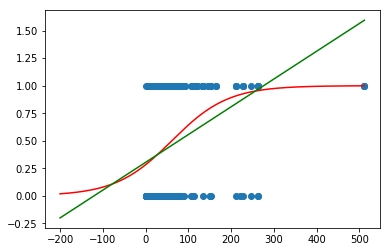

In [31]:
x = np.arange(min(X)-200,max(X),0.1)

plt.scatter(x=X,y=y)

Y = LogisticFunction(x,lm2.intercept_,lm2.coef_[0])

p=plt.plot(x,Y,'r-')

Y = RegLine(lm1,x)

p=plt.plot(x,Y,'g-')

The red line is the logistic regression fit and the green line in the linear regression fit. We can see that the fit obtained via logistic regression has range (0,1). Let's run logistic regression and include the following mix of original and engineered variables

In [83]:
variables = list(titanicCleaned.columns)[2:]
print(variables)

['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'NameLengthBucket', 'male', 'Q', 'S', 'Cabin', 'Dr', 'Master', 'Miss', 'Mr', 'Mrs', 'Ms', 'Rev', 'L200k', 'TotalPpl']


In [84]:
# Create our parameters X and response y
X = titanicCleaned[variables]
y = titanicCleaned['Survived']

# Split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Reshape the data to indicate that this is many observations of one parameter
#X = X.values.reshape(-1,1)

# Get the model
lm2 = LogisticRegression()

# Fit the model
lm2.fit(X_train,y_train)

# The fitted model
printoutput = 'The fitted model is: {}'.format(lm2.intercept_[0])

for i,j in enumerate(variables):
    printoutput = printoutput + ' + ' + str(lm2.coef_[0][i]) + ' * ' + j + ''
    
print(printoutput)

The fitted model is: 1.5118575166824506 + -0.3897835716575387 * Pclass + -0.019669333026743563 * Age + -0.202741658845389 * SibSp + -0.05776354965819623 * Parch + 0.005290560477949036 * Fare + 0.013188323361664615 * NameLengthBucket + -0.8320927848292078 * male + -0.08443544337192334 * Q + -0.45827632813483454 * S + 0.7354294859204279 * Cabin + -0.612727949351677 * Dr + 1.5819868321098645 * Master + 0.5437323919430365 * Miss + -1.0507885841912485 * Mr + 1.4202223529744402 * Mrs + 0.3799955565941252 * Ms + -0.7402144367970498 * Rev + 0.3060671044701362 * L200k + -0.26050520850356434 * TotalPpl


Above we have fit 19 variables, some of which existed in the original dataset and some which were engineered in the EDA section of this article. Below, we use the most naive prediction that everyone dies as the base prediction. The accuracy of this is

In [85]:
print('The accuracy if we naively predict that everyone dies is {}'.format(np.sum((y_test == 0))/np.size(y_test)))

The accuracy if we naively predict that everyone dies is 0.5932203389830508


This is a better accuracy than random choosing between survived or died as seen below

In [87]:
import random
acc = np.sum(list(map(lambda x: 1 if x > 0.5 else 0,[random.SystemRandom().randrange(0,100)/100 for i in range(len(y_test))])) == y_test)/np.size(y_test)

print('The accuracy is {:f} if we randomly choose survivors with equal probability'.format(acc))

The accuracy is 0.474576 if we randomly choose survivors with equal probability


The accuracy of the Logistic Regression is better than the naive model as we see below

In [89]:
predictions = lm2.predict(X_test)



print('The percentage of predictions that were correct using the logistic regression model is {}'.format(np.sum((predictions == y_test))/np.size(y_test)))

The percentage of predictions that were correct using the logistic regression model is 0.8372881355932204


Further above in this article, we specified which solver to use. Here, we used the default which is 'liblinear'. The question arises as to whether we would obtain a better prediction if we chose another solver. We can simply run this fit - test procedure with all options. This is where GridSearchCV helps. GridSearchCV takes an estimator and a parameter list and exhausts all possible combinations of the parameters given in order to assess the score (in our case this will be the accuracy) of each combination. GridSearchCV utilises the cross validation method in order to run the model multiple times with different test/train splits of the dataset. We will utilise this separately in order to validate the results.

First, we import the relevant modules

In [90]:
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import cross_val_score

GridSearchCV often prints warnings in cases where convergence has not been achieved when testing an estimator with certain parameters. Here, we will suppress these warnings by intercepting them

In [92]:
# Ignore warnings from grid search
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

Below, we have 2 estimators: A default logistic regression estimator where the parameters are left as defaults; and an optimised logistic regression model which is obtained from the GridSearchCV fit. 

In [94]:
# The default model
logreg_default = LogisticRegression()

# Here, we split the parameters list into 2 dictionaries. This is because we do not want GridSearchCV to run
# anything other than the liblinear solver when dual = true
param_grid1 = {'solver':['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'],'dual':[False],'tol':[0.1,0.01,0.001,0.0002,0.0001,0.00008]}
param_grid2 = {'solver':['liblinear'],'dual':[True],'tol':[0.1,0.01,0.001,0.005,0.0001,0.0005]}
param_grid = [param_grid1,param_grid2]

# We can call the GridSearchCV for the logistic regression estimator so that it can iterate the calling
# of the fitting and the scoring of the model for different combinations of the parameters list
# We specify cv=100 meaning that for each combination of the parameters, run 100 cross validations 
# Verbose allows the output of the progress, the higher the integer the more active the outputting. 
# n_jobs specifies the maximum number of fits that can be 
# performed in parallel
gs = GridSearchCV(estimator=LogisticRegression(),param_grid=param_grid,cv=100, verbose=3,n_jobs=4)
gs.fit(X,y)
logreg_optimised = gs.best_estimator_
print('Default model parameters\n',logreg_default)
print('\n\n Optimised model parameters\n',logreg_optimised)

Fitting 100 folds for each of 36 candidates, totalling 3600 fits


[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done 1993 tasks      | elapsed:   21.5s
[Parallel(n_jobs=4)]: Done 3093 tasks      | elapsed:   42.9s


Default model parameters
 LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


 Optimised model parameters
 LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0002,
          verbose=0, warm_start=False)


[Parallel(n_jobs=4)]: Done 3600 out of 3600 | elapsed:   46.4s finished


We see that the optimised model is almost the same as the default. Checking below that applying 300 cross validations on each estimator reveals that they both perform equally well.

In [95]:
logreg_default_scores = cross_val_score(logreg_default, X, y, cv=300, scoring='accuracy',n_jobs=4)
logreg_optimised_scores = cross_val_score(logreg_optimised, X, y, cv=300, scoring='accuracy',n_jobs=4)
print('The default classifier mean accuracy score is {}'.format(logreg_default_scores.mean()))
print('The optimised classifier mean accuracy score is {}'.format(logreg_optimised_scores.mean()))

The default classifier mean accuracy score is 0.836111111111111
The optimised classifier mean accuracy score is 0.836111111111111
